# FWI a partir de un modelo de velocidad de onda p inicial creado con InversionNet

### Pliegues del dataset curvevel_b (OpenFWI)

**Importando librerías**

In [2]:
import numpy as np  
import matplotlib.pyplot as plt
from sympy import Min, Max

from devito import configuration, Function, norm, mmax, Eq, Operator

from examples.seismic import Model, plot_velocity, plot_image, plot_shotrecord, AcquisitionGeometry, Receiver
from examples.seismic.acoustic import AcousticWaveSolver


configuration['log-level'] = "ERROR"



**Parametros de adquisición**

In [3]:
nshots = 40  # Numero de disparos
nreceivers = 80  # Numero de receptores por disparo
fwi_iterations = 350 # Número de iteraciones de FWI

shape = (70, 70)  # (nx, nz)
spacing = (10., 10.)  # espaciamiento en m
origin = (0., 0.)  # origen

t0 = 0. #Tiempo inicial
tn = 1000. #Tiempo final (ms)
f0 = 0.015 #Frecuencia: 10 Hertzh

**Modelo verdadero (pliegues)**

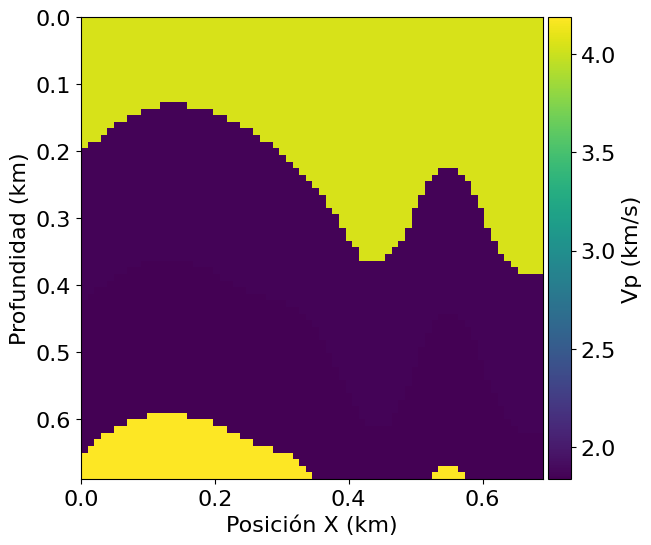

In [13]:
m_truth = np.load('Verdadero1.npy') #Modelo en m/s
m_truth=m_truth[10]/1000 #Modelo en km/s
m_truth=np.squeeze(m_truth) #Modelo de formato (1,70,70) a (70,70)
m_truth= np.swapaxes(m_truth,1,0) #Se se voltea el modelo (la predicción lo generó así)


model = Model(vp=m_truth, origin=origin, spacing=spacing, dtype=np.float32,
               shape=shape, space_order=2, bcs='damp', nbl=40)

plot_velocity(model)

**Creación del modelo inicial (creado en InversionNet)**

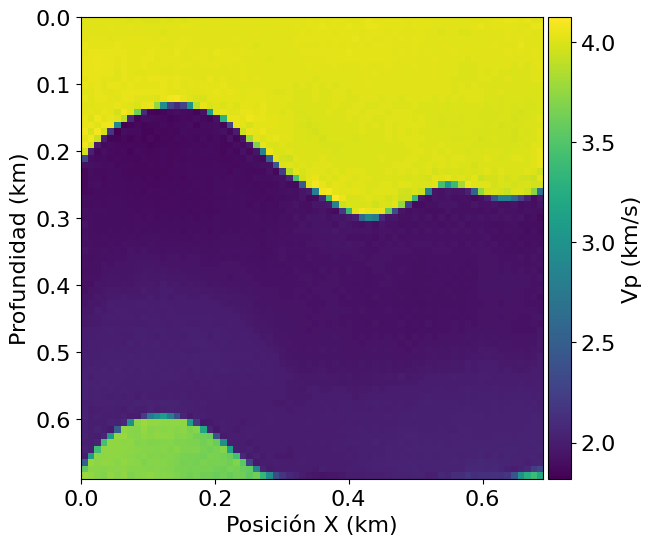

In [11]:
m = np.load('Inversionet1.npy') #Modelo en m/s
m=m[10]/1000 #Modelo en km/s
m=np.squeeze(m) #Modelo de formato (1,70,70) a (70,70)
m = np.swapaxes(m,1,0) #Se se voltea el modelo (la predicción lo generó así)


#Convirtiendo el modelo en un objeto SeismicModel
model0 = Model(vp=m, origin=origin, spacing=spacing, dtype=np.float32,
               shape=shape, space_order=2, bcs='damp', nbl=40)  

plot_velocity(model0)

**Graficando la geometría de adquisición**

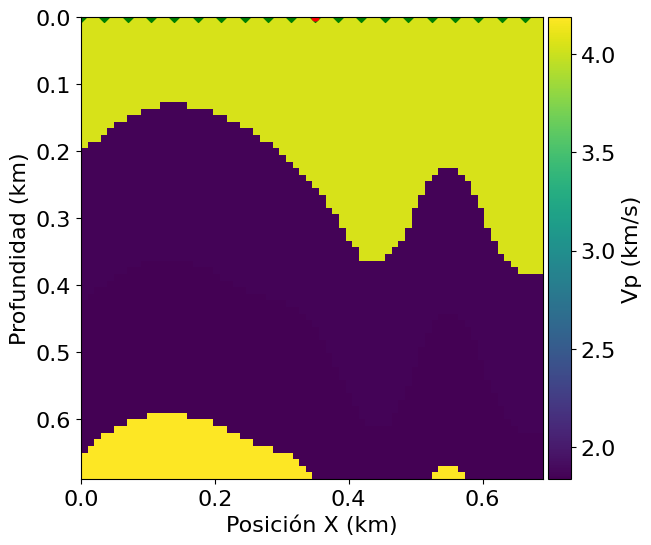

In [14]:
# Posiciones de las fuentes
src_coordinates = np.empty((1, 2))
src_coordinates[:,0] = 350 #X
src_coordinates[:,1] = 0  #Y

# Posiciones de los receptores
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers) #X
rec_coordinates[:, 1] =  0 #Y

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')

plot_velocity(model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])


**Forward modelling**

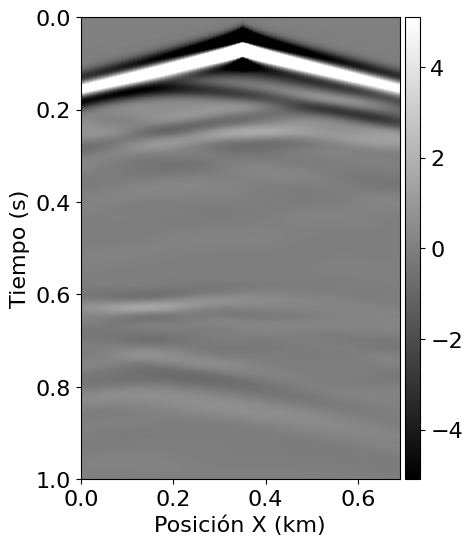

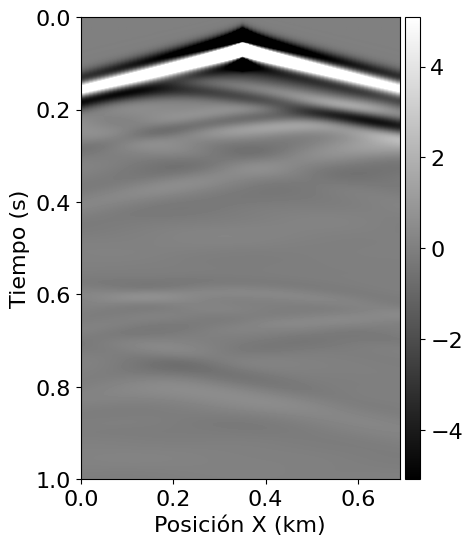

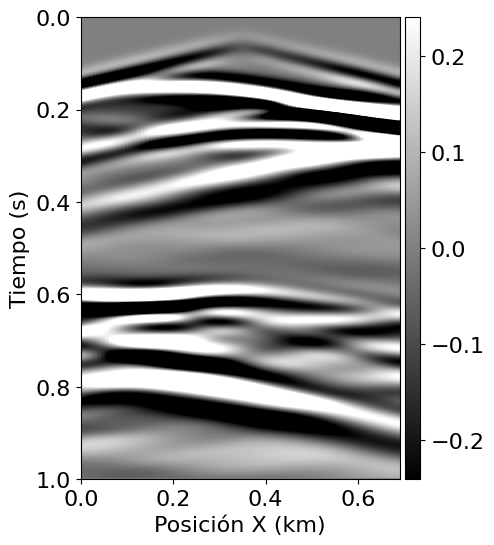

In [15]:
#Configuración del operador directo
solver = AcousticWaveSolver(model, geometry, space_order=4)

true_d, _, _ = solver.forward(vp=model.vp)

smooth_d, _, _ = solver.forward(vp=model0.vp)

#Graficar los datos sísmicos
plot_shotrecord(true_d.data, model, t0, tn) #Datos observados
plot_shotrecord(smooth_d.data, model, t0, tn) #Datos sintéticos
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn) #Diferencia entre estos datos



**Preparación de las fuentes para generar todos los shots iterativamente para el cálculo de gradiente**

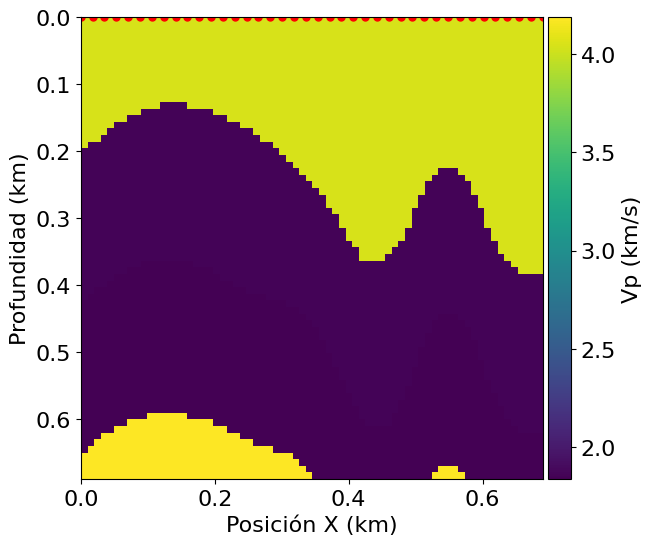

In [16]:
#Preparar la iteración de fuentes para el cálculo de gradiente
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0, model.domain_size[0], num=nshots) #X
source_locations[:, 1] = 0 #Y

#Se muestran TODAS las fuentes
plot_velocity(model, source=source_locations)

**Cálculo de residuos y creación de la función del gradiente con objetivo norma l2 (función de costo)**

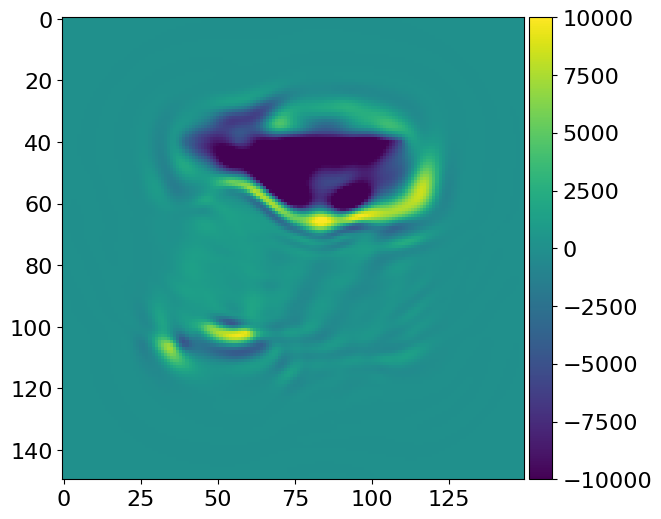

In [17]:
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        #Asegurar que las dimensiones y posiciones entre datos concuerdan
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        #Crear operador diferencial
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    
    return residual

def fwi_gradient(vp_in):    
   
    grad = Function(name="grad", grid=model.grid)

    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Se actualiza la posición de la fuente para cada iteración en el rango nshots
        geometry.src_positions[0,:] = source_locations[i,:]
        
        # Generar datos sintéticos
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        #Computar gradiente y actualizar la función objetivo (función de costo)
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2 #norma L2 (función de costo)
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, grad

#Computar gradiente del modelo inicial
ff, update = fwi_gradient(model0.vp)

#Gráfica del gradiente
plot_image(-update.data, vmin=-1e4, vmax=1e4, cmap="viridis")

**Muestra lo que la actualización le hace al modelo**

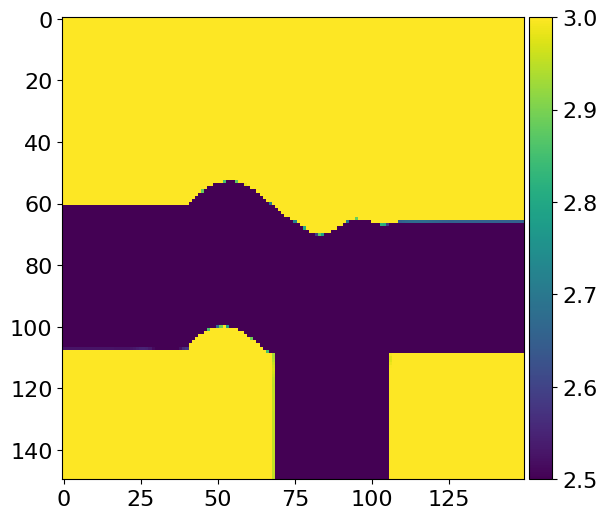

In [18]:
alpha = .5 / mmax(update)
plot_image(model0.vp.data + alpha*update.data, vmin=2.5, vmax=3.0, cmap="viridis")

**Actualización del modelo iterativamente con el método steepest descent**

La función de costo es 101737.437500 en la iteración 1
La función de costo es 1367067.875000 en la iteración 2
La función de costo es 1361000.500000 en la iteración 3
La función de costo es 1354931.250000 en la iteración 4
La función de costo es 1348860.375000 en la iteración 5
La función de costo es 1342788.875000 en la iteración 6
La función de costo es 1336719.875000 en la iteración 7
La función de costo es 1330652.750000 en la iteración 8
La función de costo es 1324591.000000 en la iteración 9
La función de costo es 1318535.000000 en la iteración 10
La función de costo es 1312485.250000 en la iteración 11
La función de costo es 1306443.875000 en la iteración 12
La función de costo es 1300412.625000 en la iteración 13
La función de costo es 1294392.000000 en la iteración 14
La función de costo es 1288384.375000 en la iteración 15
La función de costo es 1282390.000000 en la iteración 16
La función de costo es 1276411.375000 en la iteración 17
La función de costo es 1270449.875000 en 

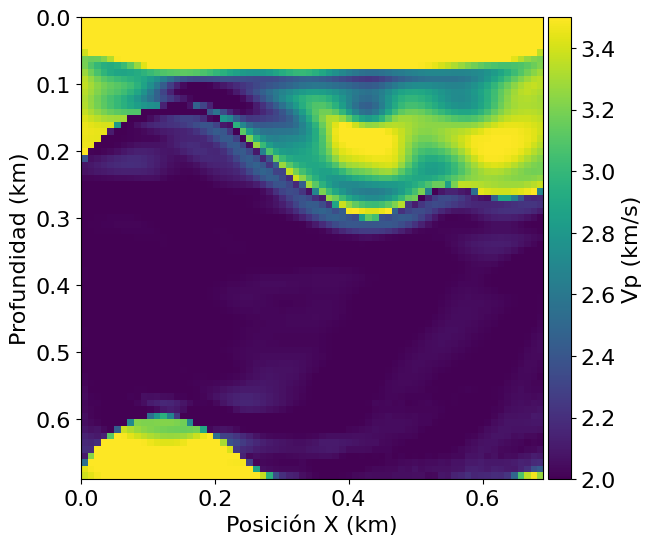

In [19]:
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
   
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
  
    phi, direction = fwi_gradient(model0.vp)
    
    history[i] = phi
    
    #longitud de paso (learning rate)
    alpha = .05 / mmax(direction)
    
    update_with_box(model0.vp , alpha , direction)
    
    print('La función de costo es %f en la iteración %d' % (phi, i+1))

#Modelo invertido (modelo inicial al que se le va sumando o restando el gradiente en cada iteración)
plot_velocity(model0)

**Decaimiento de la función de costo**

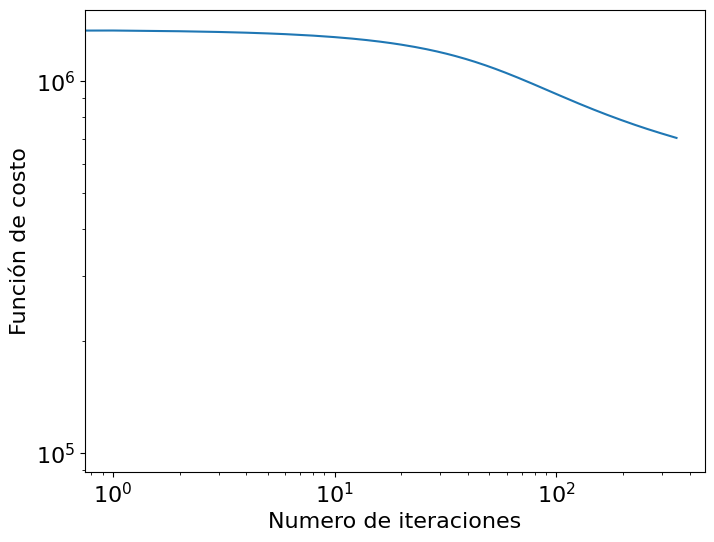

In [20]:
plt.figure()
plt.loglog(history)
plt.xlabel('Numero de iteraciones')
plt.ylabel('Función de costo')
plt.show()